<a href="https://colab.research.google.com/github/mrudulagavas/All-About-AI-ML/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT: Classify spam vs no spam emails

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

,count
Category,
ham,4825
spam,747


In [5]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

,count
Category,
ham,747
spam,747


In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
252,ham,"Wen ur lovable bcums angry wid u, dnt take it ...",0
2264,spam,Not heard from U4 a while. Call 4 rude chat pr...,1
2715,ham,I am thinking of going down to reg for pract l...,0
1136,ham,K do I need a login or anything,0
4091,spam,We tried to call you re your reply to our sms ...,1


Split it into training and test data set

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [13]:
X_train.head(4)

,Message
268,Ur ringtone service has changed! 25 Free credi...
3789,Want to funk up ur fone with a weekly new tone...
188,Please call our customer service representativ...
4104,U have a secret admirer who is looking 2 make ...


Importing BERT Model

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [15]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435168 , -0.5132727 , -0.88845724, ..., -0.7474888 ,
        -0.7531474 ,  0.91964483],
       [-0.87208354, -0.50543964, -0.9444667 , ..., -0.858475  ,
        -0.7174534 ,  0.88082963]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [16]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [18]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703815]], dtype=float32)

In [19]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

Build Model

In [20]:
!pip install --upgrade tensorflow==2.12 tensorflow-hub==0.13.0 tensorflow-text==2.12

In [21]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Load layers
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="bert_preprocess")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name="bert_encoder")

# Build model
text_input = tf.keras.Input(shape=(), dtype=tf.string, name="text")
preprocessed_inputs = bert_preprocess(text_input)
encoder_outputs = bert_encoder(preprocessed_inputs)

pooled_output = encoder_outputs["pooled_output"]
dropout = tf.keras.layers.Dropout(0.1)(pooled_output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

model = tf.keras.Model(inputs=text_input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 bert_preprocess (KerasLayer)   {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [22]:
len(X_train)

1120

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model



In [24]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 1109s 31s/step - loss: 0.9545 - accuracy: 0.5063 - precision: 0.5063 - recall: 0.5036
Epoch 2/10
35/35 [==============================] - 1053s 30s/step - loss: 0.7548 - accuracy: 0.4839 - precision: 0.4828 - recall: 0.4518
Epoch 3/10
35/35 [==============================] - 1047s 30s/step - loss: 0.7352 - accuracy: 0.5071 - precision: 0.5069 - recall: 0.5250
Epoch 4/10
35/35 [==============================] - 1048s 30s/step - loss: 0.7246 - accuracy: 0.5009 - precision: 0.5010 - recall: 0.4375
Epoch 5/10
35/35 [==============================] - 1055s 30s/step - loss: 0.7152 - accuracy: 0.5009 - precision: 0.5008 - recall: 0.5607
Epoch 6/10
35/35 [==============================] - 1017s 29s/step - loss: 0.7112 - accuracy: 0.5143 - precision: 0.5146 - recall: 0.5036
Epoch 7/10
35/35 [==============================] - 1019s 29s/step - loss: 0.7364 - accuracy: 0.4929 - precision: 0.4932 - recall: 0.5196
Epoch 8/10
35/35 [================

In [25]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 108s 9s/step - loss: 0.6932 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000


[0.6932051777839661, 0.5, 0.5, 1.0]

In [26]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 106s 9s/step


In [27]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[  0, 187],
       [  0, 187]])

Text(50.722222222222214, 0.5, 'Truth')

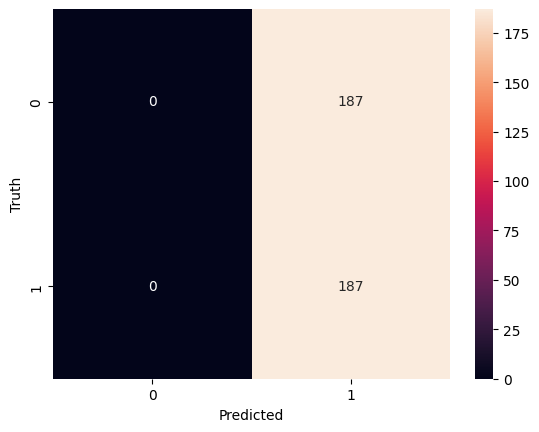

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       187
           1       0.50      1.00      0.67       187

    accuracy                           0.50       374
   macro avg       0.25      0.50      0.33       374
weighted avg       0.25      0.50      0.33       374



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Example

In [31]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.50538564],
       [0.5053856 ],
       [0.5053856 ],
       [0.5053856 ],
       [0.5053856 ]], dtype=float32)